In [84]:
# 1. Setup & Imports

## Core libraries
import pandas as pd
import numpy as np

# 📊 Modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 📈 Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 🧪 Reproducibility
RANDOM_SEED = 42


In [85]:
# 2. Load Data

df = pd.read_csv("../data/simulated/signal_latest.csv")
print(f"✅ Loaded {len(df)} rows")
df.head()







✅ Loaded 175200 rows


,time,relative_humidity_2m,pressure_msl,cloudcover,windspeed_10m,rain_rate,location,temperature_celsius,hour,day,month,weekday,signal_dbm
0,2023-01-01 00:00:00,95.000000,1016.9,95,7.6,0.0,seattle,3.1,0,1,1,6,-77.381955
1,2023-01-01 01:00:00,95.000000,1017.5,71,6.5,0.5,seattle,3.9,1,1,1,6,-75.006582
2,2023-01-01 02:00:00,95.487136,1017.9,74,6.6,0.0,seattle,3.5,2,1,1,6,-77.287053
3,2023-01-01 03:00:00,98.000000,1018.5,94,7.2,0.0,seattle,2.8,3,1,1,6,-82.144823
4,2023-01-01 04:00:00,98.000000,1019.1,100,7.4,0.0,seattle,2.6,4,1,1,6,-79.333464


In [86]:
missing_summary = df.isna().sum()
print(missing_summary[missing_summary > 0])

relative_humidity_2m    3501
windspeed_10m           3436
rain_rate               3546
dtype: int64


In [87]:
def handle_null_values(df):
    missing_summary = df.isna().sum()
    cols_with_null =  missing_summary[missing_summary > 0]
    print(f'null cols: {cols_with_null}')
    for col in cols_with_null.index:
        print(f"col: {col}")
        df[col] = df.groupby('location')[col].transform(lambda group: group.ffill().bfill())
    return df
df_clean = handle_null_values(df)

null cols: relative_humidity_2m    3501
windspeed_10m           3436
rain_rate               3546
dtype: int64
col: relative_humidity_2m
col: windspeed_10m
col: rain_rate


In [88]:
df['relative_humidity_2m'] = (df.groupby('location')['relative_humidity_2m'].transform(lambda group: group.ffill().bfill()))
df['windspeed_10m'] = (df.groupby('location')['windspeed_10m'].transform(lambda group: group.ffill().bfill()))
df['rain_rate'] = (df.groupby('location')['rain_rate'].transform(lambda group: group.ffill().bfill()))

In [89]:
df.isnull().sum()

time                    0
relative_humidity_2m    0
pressure_msl            0
cloudcover              0
windspeed_10m           0
rain_rate               0
location                0
temperature_celsius     0
hour                    0
day                     0
month                   0
weekday                 0
signal_dbm              0
dtype: int64

_IncompleteInputError: incomplete input (1286254937.py, line 1)

In [54]:
# 3. Define X and y

# Target
y = df["signal_dbm"]

# Features
feature_cols = [
    "rain_rate", "relative_humidity_2m", "pressure_msl", "cloudcover",
    "windspeed_10m", "temperature_celsius", "hour", "day", "month", "weekday"
]
X = df[feature_cols]


In [55]:
# 4. Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)


In [56]:
# 5. Baseline Model: Linear Regression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred_lr)
# Calculate MSE first, then take the square root to get RMSE
mse = mean_squared_error(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2 = r2_score(y_test, y_pred_lr)

print(f"Linear Regression — MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")


Linear Regression — MAE: 2.17, RMSE: 2.84, R²: 0.64


In [57]:
# 6. Try Random Forest

rf = RandomForestRegressor(random_state=RANDOM_SEED)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"🌲 Random Forest — MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, R²: {r2_rf:.2f}")


🌲 Random Forest — MAE: 2.14, RMSE: 2.78, R²: 0.65


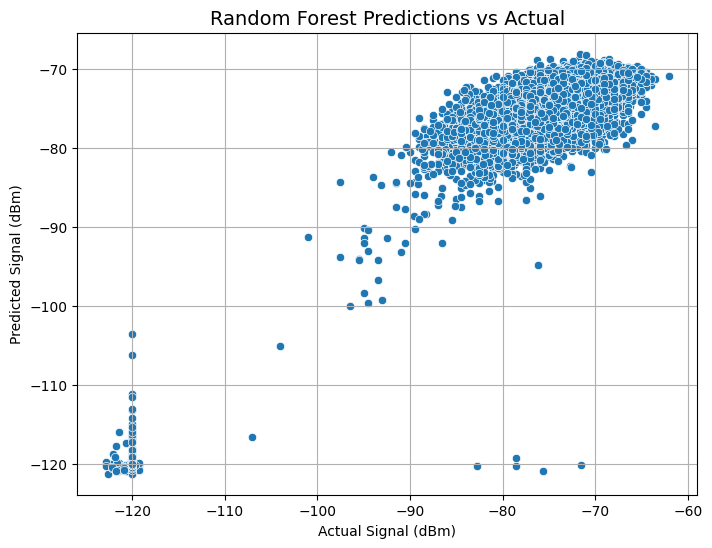

In [59]:
# 7. Visualize Predictions

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.xlabel("Actual Signal (dBm)")
plt.ylabel("Predicted Signal (dBm)")
plt.title("Random Forest Predictions vs Actual", fontsize=14)
plt.grid(True)
plt.show()


<Axes: title={'center': 'Feature Importance'}, xlabel='feature'>

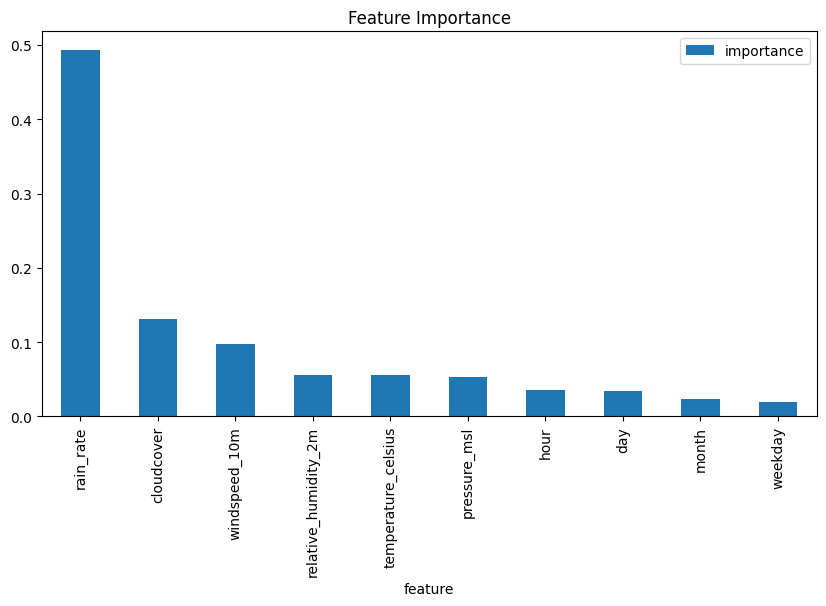

In [60]:
# 8. Feature Importance (if model supports it)

importances = rf.feature_importances_
feat_df = pd.DataFrame({"feature": feature_cols, "importance": importances})
feat_df.sort_values("importance", ascending=False).plot.bar(x="feature", figsize=(10, 5), title="Feature Importance")


In [31]:
# Modeling with Top 5 Features

In [61]:
top_features = [
    "cloudcover",
    "relative_humidity_2m",
    "windspeed_10m",
    "rain_rate",
    "temperature_celsius"  # assuming you've already renamed it
]
X_top = df[top_features]
y = df["signal_dbm"]

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=RANDOM_SEED)

In [63]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"📊 Linear Regression — MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}, R²: {r2_lr:.2f}")

📊 Linear Regression — MAE: 2.17, RMSE: 2.84, R²: 0.64


In [65]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"🌲 Random Forest — MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, R²: {r2_rf:.2f}")

🌲 Random Forest — MAE: 2.20, RMSE: 2.86, R²: 0.63
